## Reproducing the correlation anlaysis of the evolutionary expansion map to various brain maps

In [1]:
import neuromaps
print("neuromaps version:", neuromaps.__version__)

neuromaps version: 0+untagged.16.g15e0bbd.dirty


#### *Make sure to have Connectome Workbench installed*

In [2]:
## run if needed
# pip install neuromaps brainspace
# pip install statsmodels

In [3]:
# Add more imports if needed

from neuromaps.datasets import fetch_atlas ## used to access the templates for the coordinate system
import nibabel as nib ## used to load system dictionary per key
from neuromaps.datasets import available_annotations ## repository of brain maps - spatial maps representing some
from neuromaps.datasets import available_tags ## most annotations have “tags” that help to describe the data they represent
from neuromaps.datasets import fetch_annotation
from neuromaps.datasets import fetch_fsaverage

from neuromaps import transforms
import netneurotools
# possibly need
from netneurotools import datasets as nntdata
from neuromaps import parcellate
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti
# plotting 
from neuromaps.images import load_data
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from neuromaps import plotting
from nilearn import plotting
import numpy as np
import pandas as pd
# sampling
from neuromaps import datasets, images, nulls, resampling
from neuromaps.resampling import resample_images
from neuromaps.stats import compare_images
from neuromaps import stats
from nilearn.datasets import fetch_atlas_surf_destrieux
from neuromaps.nulls import alexander_bloch
from neuromaps.stats import compare_images
from scipy.stats import pearsonr

from nilearn.surface import load_surf_mesh
from brainspace.null_models import SpinPermutations
from nilearn.surface import InMemoryMesh, PolyMesh
from nilearn.surface import SurfaceImage
from nilearn.plotting import view_surf

import time
# from neuromaps.stats import fdr_correct
# for FDR
from statsmodels.stats.multitest import multipletests

#### Our Source Map

In [4]:
# Note: source_map will be used later in the full_spin_test function
source_map = {'source':'hill2010', 'desc':'evoexp', 'space':'fsLR', 'den':'164k'}
# Demonstration on fetching the path to the data map file that is used in the full_spin_test function shown later
evolutionary_expansion_map = fetch_annotation(**source_map)
evolutionary_expansion_map


[References] Please cite the following papers if you are using this data:

  For {'source': 'hill2010', 'desc': 'evoexp', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Jason Hill, Terrie Inder, Jeffrey Neil, Donna Dierker, John Harwell, and David Van Essen. Similar patterns of cortical expansion during human development and evolution. Proceedings of the National Academy of Sciences, 107(29):13135–13140, 2010.
  [secondary]:
    


'/Users/kevin/neuromaps-data/annotations/hill2010/evoexp/fsLR/source-hill2010_desc-evoexp_space-fsLR_den-164k_hemi-R_feature.func.gii'

#### Our Target Maps

In [5]:
# Note: these will be used later in the full_spin_test function
target_maps = [
    {'source':'abagen', 'desc':'genepc1', 'space':'fsaverage', 'den':'10k'},
    {'source':'hcps1200', 'desc':'myelinmap', 'space':'fsLR', 'den':'32k'},
    {'source':'hcps1200', 'desc':'thickness', 'space':'fsLR', 'den':'32k'},
    {'source':'hill2010', 'desc':'devexp', 'space':'fsLR', 'den':'164k'},
    {'source':'margulies2016', 'desc':'fcgradient01', 'space':'fsLR', 'den':'32k'},
    {'source':'mueller2013', 'desc':'intersubjvar', 'space':'fsLR', 'den':'164k'},

    {'source':'raichle', 'desc':'cbf', 'space':'fsLR', 'den':'164k'},
    {'source':'raichle', 'desc':'cbv', 'space':'fsLR', 'den':'164k'},
    {'source':'raichle', 'desc':'cmr02', 'space':'fsLR', 'den':'164k'},
    {'source':'raichle', 'desc':'cmrglc', 'space':'fsLR', 'den':'164k'},
    {'source':'reardon2018', 'desc':'scalingnih', 'space':'civet', 'den':'41k'},
    {'source':'reardon2018', 'desc':'scalingpnc', 'space':'civet', 'den':'41k'}
]

# Official names for plotting later
map_names = {
    'genepc1': 'PC1 Gene Expression',
    'myelinmap': 'T1w/T2w Ratio',
    'thickness': 'Cortical Thickness',
    'devexp': 'Developmental Expansion',
    'fcgradient01': 'Functional Gradient',
    'intersubjvar': 'Intersubject Variability',
    'cbf': 'Cerebral Blood Flow',
    'cbv': 'Cerebral Blood Volume',
    'cmr02': 'Oxygen Metabolism',
    'cmrglc': 'Glucose Metabolism',
    'scalingnih': 'Allometric Scaling (NIH)',
    'scalingpnc': 'Allometric Scaling (PNC)',
    'evoexp': 'Evolutionary Expansion'
}

#### Implementing the Spin Test for our Target Maps

Also demonstrates transforming brain maps to different coordinate systems and densities

In [6]:
def full_spin_test(src: dict, trg: dict):
    """
    Performs the Alexander Bloch spin test between the source map and target map
    Parameters:
    src: the source map as a dictionary with the needed parameters for feth_annotation
    trg: the target maps as a dictionary with the needed parameters for feth_annotation
    Outputs: A list of dictionaries 
    """
    src_paper, src_desc, src_space, src_den = src.values()
    trg_paper, trg_desc, trg_space, trg_den = trg.values()

    #fetch source map and target map files
    start = time.perf_counter() #timing just for user info
    src_map = datasets.fetch_annotation(**src)
    trg_map = datasets.fetch_annotation(**trg)

    #if target map has both hemispheres, use only the right one
    #our source map only contains data for the right hemisphere
    if(len(trg_map)==2):
        trg_map = trg_map[1]
    if src_den != trg_den:
        src_res, trg_res = resampling.resample_images(
            src_map,
            trg_map,
            src_space=src_space,
            trg_space=trg_space,
            hemi='R',
            resampling='downsample_only' #sample to size of target map density
        )
        #load the actual data from the files
        src_data = images.load_data(src_res)
        trg_data = images.load_data(trg_res)
    else:
        src_data = images.load_data(src_map)
        trg_data = images.load_data(trg_map)
    #create nan values for left brain
    L_nan = np.full_like(src_data, np.nan)
    src_sphere = np.hstack([L_nan, src_data])
    trg_sphere = np.hstack([L_nan, trg_data])
    #spin test
    rotated = nulls.alexander_bloch(
        src_sphere,
        atlas = trg_space,
        density = trg_den,
        n_perm = 1000,
        seed = 1234
    )
    r_corr, p_value, null_dist = compare_images(
        src_sphere,
        trg_sphere,
        metric='pearsonr',
        nulls=rotated,
        return_nulls=True
    )
    end = time.perf_counter()
    time_elapsed = end - start
    print(f"Time elapsed for {trg_desc}: {time_elapsed/60:.2f} minutes")
    
    formal_name = map_names.get(trg_desc)
    results_dict = {'target map': formal_name, 
                'r_emp': r_corr, 
                'p_spin': p_value, 
                'nulls': null_dist
               }
    return results_dict

In [7]:
results = []
for trg_map in target_maps:
    results.append(full_spin_test(source_map, trg_map))

results_df = pd.DataFrame(results)
display(results_df)

# note code took 80 minutes to run


[References] Please cite the following papers if you are using this data:

  For {'source': 'hill2010', 'desc': 'evoexp', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Jason Hill, Terrie Inder, Jeffrey Neil, Donna Dierker, John Harwell, and David Van Essen. Similar patterns of cortical expansion during human development and evolution. Proceedings of the National Academy of Sciences, 107(29):13135–13140, 2010.
  [secondary]:
    

[References] Please cite the following papers if you are using this data:

  For {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'}:
  [primary]:
    Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391, 2012.
    Ross D Markello, Aurina Arnatkeviciute, Jean-Baptiste Poline, Ben D Fulcher, Alex Forn

,target map,r_emp,p_spin,nulls
0,PC1 Gene Expression,-0.511533,0.039960,"[-0.15936285257339478, 0.0996677353978157, -0...."
1,T1w/T2w Ratio,-0.464927,0.004995,"[-0.1488165557384491, -0.04746032506227493, -0..."
2,Cortical Thickness,0.314704,0.134865,"[0.20498232543468475, -0.03370446339249611, 0...."
3,Developmental Expansion,0.353514,0.019980,"[0.07768141478300095, -0.03526309132575989, -0..."
4,Functional Gradient,0.340805,0.074925,"[0.2926594614982605, 0.24892891943454742, 0.01..."
5,Intersubject Variability,0.575390,0.004995,"[0.2097356617450714, -0.32237765192985535, -0...."
6,Cerebral Blood Flow,-0.099610,0.628372,"[-0.01722114346921444, -0.14746685326099396, -..."
7,Cerebral Blood Volume,-0.367210,0.002997,"[-0.04798315837979317, 0.06807340681552887, 0...."
8,Oxygen Metabolism,-0.180269,0.384615,"[-0.00784066691994667, -0.08763530850410461, -..."
9,Glucose Metabolism,0.042035,0.889111,"[0.04871498793363571, -0.11166742444038391, -0..."


In [8]:
# # Outputting results to a CSV file
# results_df.to_csv('spin_test_results.csv', index=False)

#### False Discovery Rate

In [11]:
## False Discovery Rate Calculation
## Multiple Comparison Tests

p_vals = np.array(results_df['p_spin'])

# Benjamini–Hochberg FDR
reject_fdr, p_fdr, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
# Benjamini–Yekutieli FDR
reject_BY, p_BY, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_by')
# Bonferroni correction
reject_bonf, p_bonf, _, _ = multipletests(p_vals, alpha=0.05, method='bonferroni')

results_df['p_FDR'] = p_fdr
results_df['reject_FDR'] = reject_fdr
results_df['p_FDR_BY'] = p_BY
results_df['reject_FDR_BY'] = reject_BY
results_df['p_Bonf'] = p_bonf
results_df['reject_Bonf'] = reject_bonf
results_df['reject_uncorrected'] = results_df['p_spin'] < 0.05

summary_df = results_df[['target map', 'p_spin', 'reject_uncorrected', 'p_FDR', 'reject_FDR', 'p_FDR_BY','reject_FDR_BY' ,'p_Bonf', 'reject_Bonf']].copy()
summary_df.columns = [
    'Target map',
    'p_spin (uncorrected)',
    'Significant (p<0.05)',
    'p_FDR (BH corrected)',
    'Significant (FDR<0.05)',
    'p_FDR (BY corrected)',
    'Significant (FDR<0.05)',
    'p_Bonferroni (corrected)',
    'Significant (Bonf<0.05)'
]
summary_df = summary_df.round(4)

print("Summary of results:")
display(summary_df)

Summary of results:


,Target map,p_spin (uncorrected),Significant (p<0.05),p_FDR (BH corrected),Significant (FDR<0.05),p_FDR (BY corrected),Significant (FDR<0.05),p_Bonferroni (corrected),Significant (Bonf<0.05)
0,PC1 Gene Expression,0.0400,True,0.0685,False,0.2126,False,0.4795,False
1,T1w/T2w Ratio,0.0050,True,0.0200,True,0.0620,False,0.0599,False
2,Cortical Thickness,0.1349,False,0.1798,False,0.5580,False,1.0000,False
3,Developmental Expansion,0.0200,True,0.0420,True,0.1302,False,0.2398,False
4,Functional Gradient,0.0749,False,0.1124,False,0.3488,False,0.8991,False
5,Intersubject Variability,0.0050,True,0.0200,True,0.0620,False,0.0599,False
6,Cerebral Blood Flow,0.6284,False,0.6855,False,1.0000,False,1.0000,False
7,Cerebral Blood Volume,0.0030,True,0.0200,True,0.0620,False,0.0360,True
8,Oxygen Metabolism,0.3846,False,0.4615,False,1.0000,False,1.0000,False
9,Glucose Metabolism,0.8891,False,0.8891,False,1.0000,False,1.0000,False


In [ ]:
# # Outputting multiple tests results to a CSV file
# summary_df.to_csv('multiple_tests_results.csv', index=False)

### Plotting Box Plot
Our findings

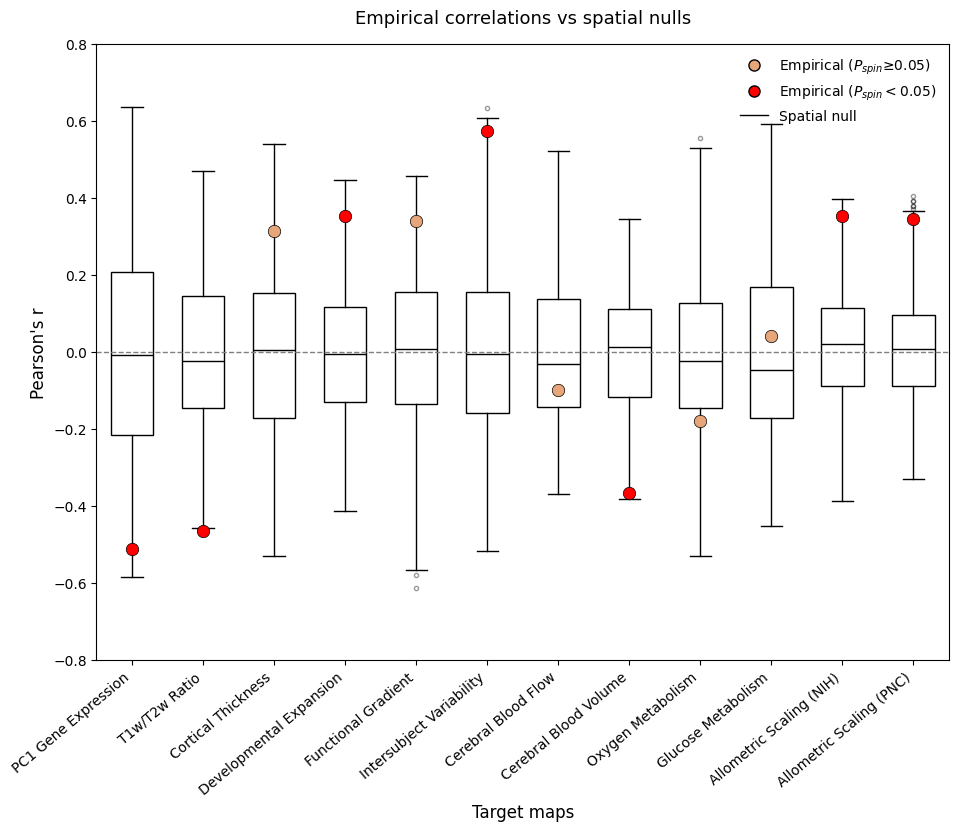

In [12]:
## Code for plotting box plots for each target map

results_df = pd.DataFrame(results)
box_data = [np.ravel(np.array(n)) for n in results_df['nulls']]
positions = np.arange(1, len(box_data) + 1)

fig, ax = plt.subplots(figsize=(11, 8))
#boxplots for target maps null distributions
bp = ax.boxplot(
    box_data,
    positions=positions,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
    medianprops=dict(color='black', linewidth=1),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    flierprops=dict(marker='o', color='gray', markersize=3, alpha=0.4)
)

#add spin test r correlation values
for i, (r, p) in enumerate(zip(results_df['r_emp'], results_df['p_spin'])):
    color = 'red' if p < 0.05 else '#e6a67a'  # red = significant, orange = non-significant
    ax.scatter(
        positions[i],
        r,
        color=color,
        s=80,
        edgecolor='black',
        linewidth=0.5,
        zorder=3
    )

ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_xticks(positions)
ax.set_xticklabels(results_df['target map'], rotation=40, ha='right', fontsize=10)
ax.set_ylabel("Pearson's r", fontsize=12)
ax.set_xlabel("Target maps", fontsize=12)
ax.set_ylim(-0.8, 0.8)
ax.set_title("Empirical correlations vs spatial nulls", fontsize=13, pad=15)

#legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=r'Empirical ($P_{spin} ≥ 0.05$)',
           markerfacecolor='#e6a67a', markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w',
           label=r'Empirical ($P_{spin} < 0.05$)',
           markerfacecolor='red', markeredgecolor='black', markersize=8),
    Line2D([0], [0], color='black', lw=1, label='Spatial null')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)
plt.show()

#### Target Maps

In [13]:
## dictionary for target maps plotting

brain_map_settings = {
    'evoexp': {'cmap': 'inferno', 'vmin': -2.7, 'vmax': 2.7},

    'genepc1': {'cmap': 'inferno', 'vmin': -2.7, 'vmax': 2.7},
    'myelinmap':{'cmap': 'viridis', 'vmin': None, 'vmax': None},
    'thickness': {'cmap': 'viridis', 'vmin': None, 'vmax': None},
    'devexp': {'cmap': 'inferno', 'vmin': -1, 'vmax': 1},
    'fcgradient01': {'cmap': 'viridis', 'vmin': None, 'vmax': None},
    'intersubjvar': {'cmap': 'inferno', 'vmin': None, 'vmax': None},
    
    'cbf': {'cmap': 'inferno', 'vmin': 'special_perc', 'vmax': 'special_perc'},
    'cbv': {'cmap': 'inferno', 'vmin': None, 'vmax': None},
    'cmr02': {'cmap': 'inferno', 'vmin': 'special_perc', 'vmax': 'special_perc'},
    'cmrglc': {'cmap': 'inferno', 'vmin': 'special_perc', 'vmax': 'special_perc'},
    'scalingnih': {'cmap': 'inferno', 'vmin': None, 'vmax': None},
    'scalingpnc': {'cmap': 'inferno', 'vmin': None, 'vmax': None},
}

In [14]:
def plot_brain_map(map: dict, map_names: dict, brain_map_settings: dict):
    """
    Plots the brain map given in the map dictionary
    Parameters:
    map: the map as a dictionary with the needed parameters for feth_annotation
    map_names: dictionary of formal names for readability and plot titles
    Outputs: 
        ...
    """
    start_time  = time.perf_counter() #timing just for user info

    map_paper, map_desc, map_space, map_den = map.values()
    #fetch source map and target map files
    src_map = datasets.fetch_annotation(**map)

    settings = brain_map_settings.get(map_desc, {})
    cmap = settings.get('cmap', 'inferno')

    fig = plt.figure(figsize=(10, 4))
    fslr = fetch_atlas(map_space, map_den)
    surf_mesh_left = fslr['inflated'].L
    surf_mesh_right = fslr['inflated'].R
    data_full = load_data(src_map)

    if settings.get('vmin') ==  'special_perc' and settings.get('vmax') == 'special_perc':
        vmin, vmax = np.percentile(data_full[~np.isnan(data_full)], [10, 95])
    elif settings.get('vmin') is not None and settings.get('vmax') is not None:
        vmin, vmax = settings['vmin'], settings['vmax']
    else:
        vmin, vmax = np.percentile(data_full[~np.isnan(data_full)], [3, 98])

    #if target map has both hemispheres, plot both hemispheres lateral
    if(len(src_map)==2):
        data_l = load_data(src_map[0])
        data_r = load_data(src_map[1])
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        plotting.plot_surf(
            surf_mesh=surf_mesh_left,
            surf_map=data_l,
            hemi='left',
            view='lateral',
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            colorbar=False,
            axes=ax1,
            title='Left hemisphere'
        )
        # right hemi
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        plotting.plot_surf(
            surf_mesh=surf_mesh_right,
            surf_map=data_r,
            hemi='right',
            view='lateral',
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            colorbar=False,
            axes=ax2,
            title='Right hemisphere'
        )
        # color bar
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_clim(vmin, vmax)
        cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, location='right')
        cbar.set_label(f"{map_names.get(map_desc)}({map_space} {map_den})", fontsize=11)
        plt.suptitle(f"{map_names.get(map_desc)}", fontsize=14)
        plt.show()


    else: #if only one hemisphere, only plot that hemisphere lateral and medial
        plot_kwargs = dict(
            surf_mesh=surf_mesh_right,
            surf_map=data_full,
            hemi='right',
            bg_on_data=True,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            colorbar=False
        )
        #plot right veiw
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        plotting.plot_surf(
            view='lateral',
            axes=ax1,
            **plot_kwargs
        )
        #plot from left view
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        plotting.plot_surf(
            view='medial',
            axes=ax2,
            **plot_kwargs
        )
        #color bar
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_clim(vmin, vmax)
        cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, location='right')
        cbar.set_label(f"{map_names.get(map_desc)}({map_space} {map_den})", fontsize=11)
        plt.suptitle(f"{map_names.get(map_desc)}", fontsize=14)
        plt.show()

    end_time = time.perf_counter()
    print(f"Total time for plotting: {(end_time - start_time):.2f} seconds")

    return None


[References] Please cite the following papers if you are using this data:

  For {'source': 'hill2010', 'desc': 'evoexp', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Jason Hill, Terrie Inder, Jeffrey Neil, Donna Dierker, John Harwell, and David Van Essen. Similar patterns of cortical expansion during human development and evolution. Proceedings of the National Academy of Sciences, 107(29):13135–13140, 2010.
  [secondary]:
    


/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_8237/694261398.py:85: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(
/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_8237/694261398.py:92: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(


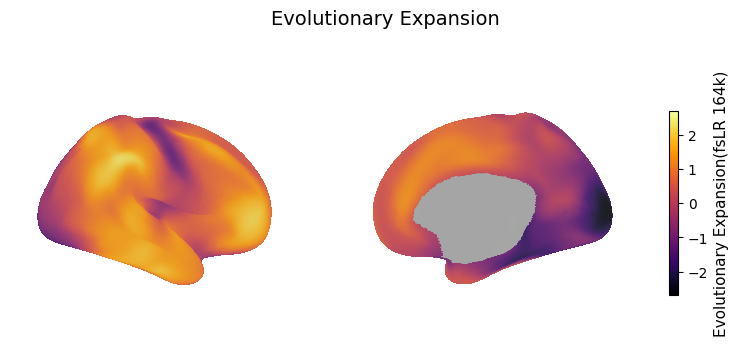

Total time for plotting: 31.80 seconds


In [15]:
source_brain_plot = plot_brain_map(source_map, map_names, brain_map_settings)
source_brain_plot


[References] Please cite the following papers if you are using this data:

  For {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'}:
  [primary]:
    Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391, 2012.
    Ross D Markello, Aurina Arnatkeviciute, Jean-Baptiste Poline, Ben D Fulcher, Alex Fornito, and Bratislav Misic. Standardizing workflows in imaging transcriptomics with the abagen toolbox. eLife, 10:e72129, 2021.
  [secondary]:
    


/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_8237/694261398.py:37: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(
/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_8237/694261398.py:51: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(


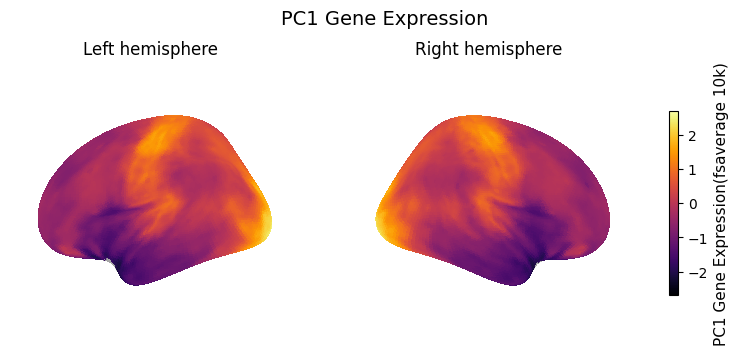

Total time for plotting: 2.66 seconds

[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'myelinmap', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jesper Andersson, Christian F Beckmann, Mark Jenkinson, and others. A multi-modal parcellation of human cerebral cortex. Nature, 536(7615):171–178, 2016.
  [secondary]:
    


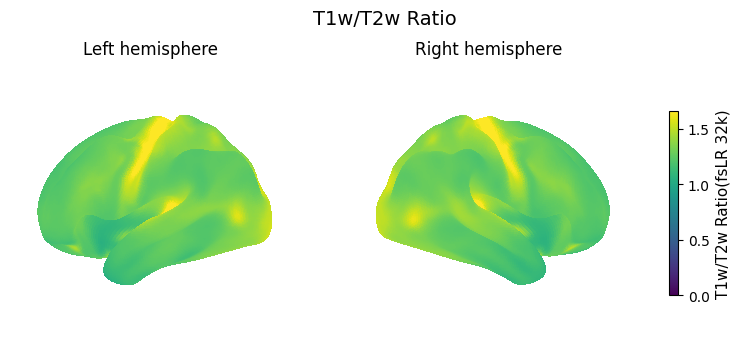

Total time for plotting: 6.73 seconds

[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jesper Andersson, Christian F Beckmann, Mark Jenkinson, and others. A multi-modal parcellation of human cerebral cortex. Nature, 536(7615):171–178, 2016.
  [secondary]:
    


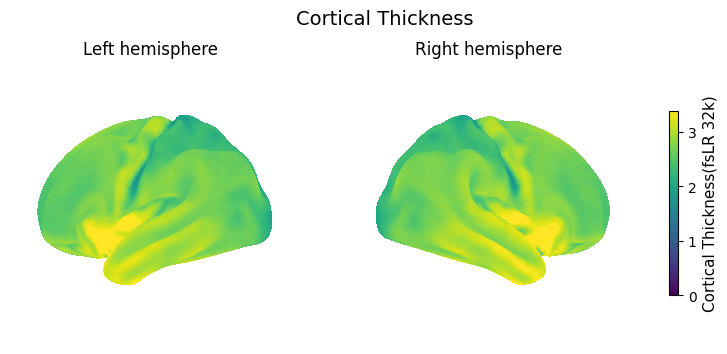

Total time for plotting: 6.43 seconds

[References] Please cite the following papers if you are using this data:

  For {'source': 'hill2010', 'desc': 'devexp', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Jason Hill, Terrie Inder, Jeffrey Neil, Donna Dierker, John Harwell, and David Van Essen. Similar patterns of cortical expansion during human development and evolution. Proceedings of the National Academy of Sciences, 107(29):13135–13140, 2010.
  [secondary]:
    


/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_8237/694261398.py:85: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(
/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_8237/694261398.py:92: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(


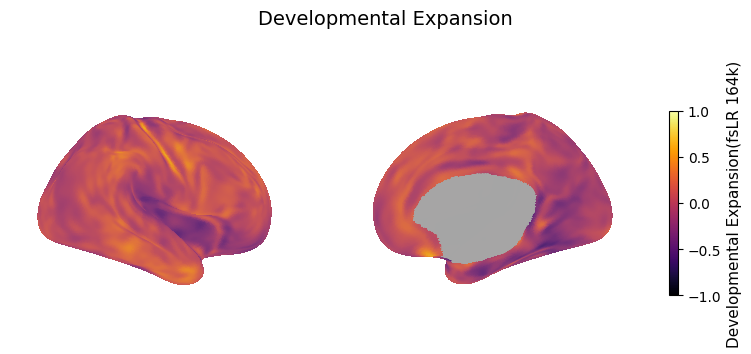

Total time for plotting: 32.29 seconds

[References] Please cite the following papers if you are using this data:

  For {'source': 'margulies2016', 'desc': 'fcgradient01', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Daniel S Margulies, Satrajit S Ghosh, Alexandros Goulas, Marcel Falkiewicz, Julia M Huntenburg, Georg Langs, Gleb Bezgin, Simon B Eickhoff, F Xavier Castellanos, Michael Petrides, and others. Situating the default-mode network along a principal gradient of macroscale cortical organization. Proc Natl Acad Sci USA, 113(44):12574–12579, 2016.
  [secondary]:
    


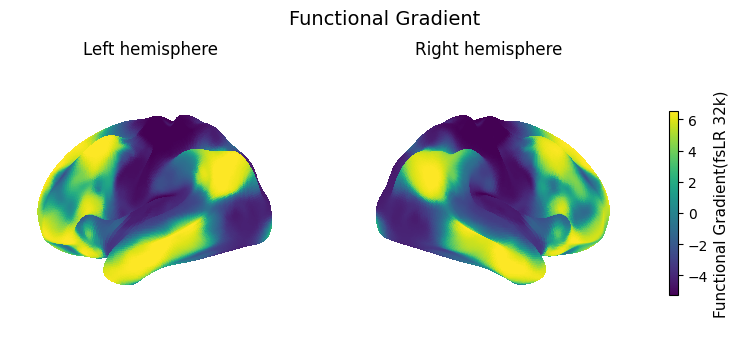

Total time for plotting: 7.00 seconds

[References] Please cite the following papers if you are using this data:

  For {'source': 'mueller2013', 'desc': 'intersubjvar', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Sophia Mueller, Danhong Wang, Michael D Fox, BT Thomas Yeo, Jorge Sepulcre, Mert R Sabuncu, Rebecca Shafee, Jie Lu, and Hesheng Liu. Individual variability in functional connectivity architecture of the human brain. Neuron, 77(3):586–595, 2013.
  [secondary]:
    


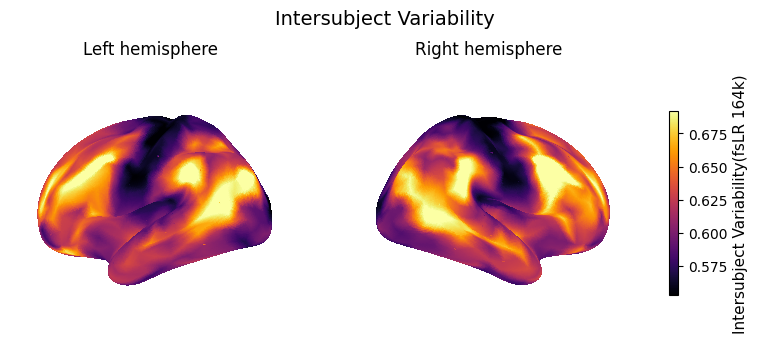

Total time for plotting: 32.72 seconds

[References] Please cite the following papers if you are using this data:

  For {'source': 'raichle', 'desc': 'cbf', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    S Neil Vaishnavi, Andrei G Vlassenko, Melissa M Rundle, Abraham Z Snyder, Mark A Mintun, and Marcus E Raichle. Regional aerobic glycolysis in the human brain. Proceedings of the National Academy of Sciences, 107(41):17757–17762, 2010.
  [secondary]:
    


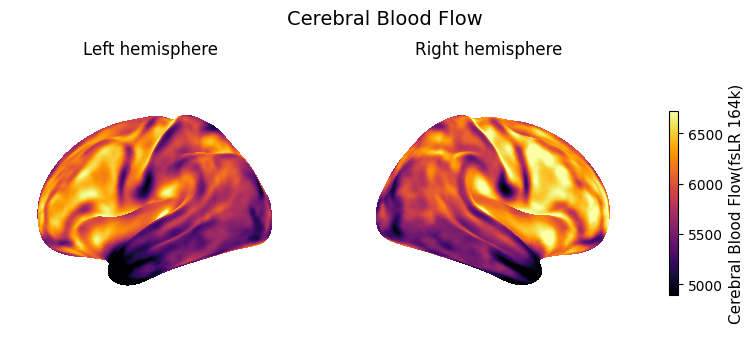

Total time for plotting: 32.68 seconds

[References] Please cite the following papers if you are using this data:

  For {'source': 'raichle', 'desc': 'cbv', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    S Neil Vaishnavi, Andrei G Vlassenko, Melissa M Rundle, Abraham Z Snyder, Mark A Mintun, and Marcus E Raichle. Regional aerobic glycolysis in the human brain. Proceedings of the National Academy of Sciences, 107(41):17757–17762, 2010.
  [secondary]:
    


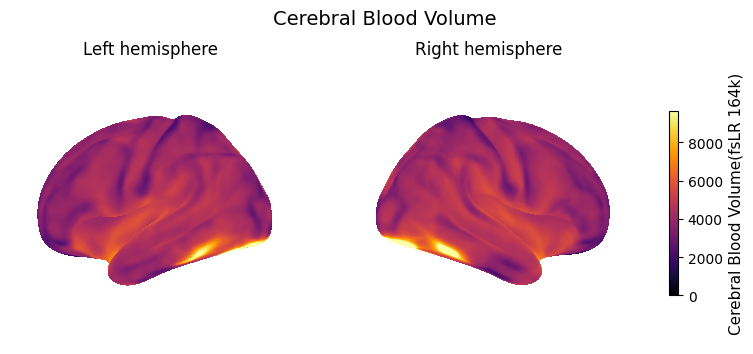

Total time for plotting: 32.29 seconds

[References] Please cite the following papers if you are using this data:

  For {'source': 'raichle', 'desc': 'cmr02', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    S Neil Vaishnavi, Andrei G Vlassenko, Melissa M Rundle, Abraham Z Snyder, Mark A Mintun, and Marcus E Raichle. Regional aerobic glycolysis in the human brain. Proceedings of the National Academy of Sciences, 107(41):17757–17762, 2010.
  [secondary]:
    


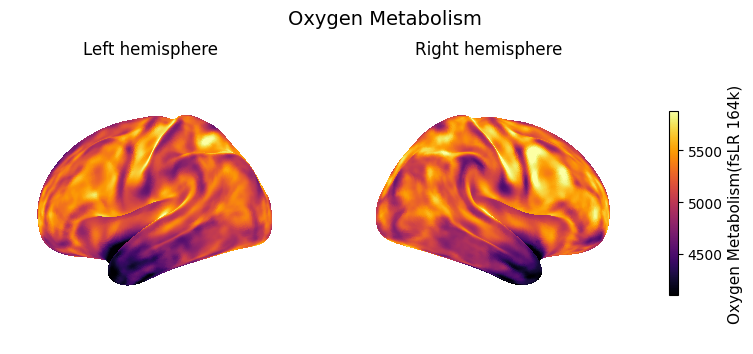

Total time for plotting: 32.89 seconds

[References] Please cite the following papers if you are using this data:

  For {'source': 'raichle', 'desc': 'cmrglc', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    S Neil Vaishnavi, Andrei G Vlassenko, Melissa M Rundle, Abraham Z Snyder, Mark A Mintun, and Marcus E Raichle. Regional aerobic glycolysis in the human brain. Proceedings of the National Academy of Sciences, 107(41):17757–17762, 2010.
  [secondary]:
    


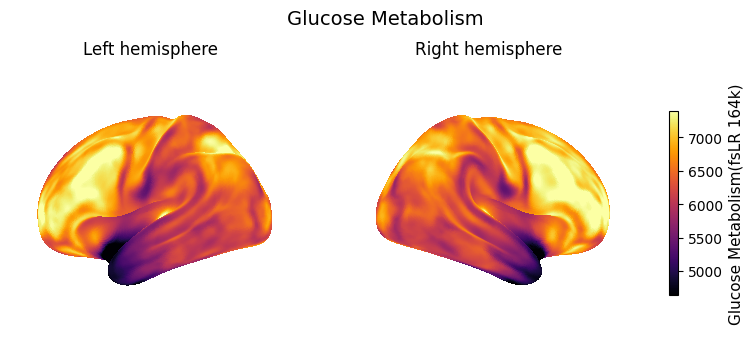

Total time for plotting: 32.90 seconds

[References] Please cite the following papers if you are using this data:

  For {'source': 'reardon2018', 'desc': 'scalingnih', 'space': 'civet', 'den': '41k'}:
  [primary]:
    PK Reardon, Jakob Seidlitz, Simon Vandekar, Siyuan Liu, Raihaan Patel, Min Tae M Park, Aaron Alexander-Bloch, Liv S Clasen, Jonathan D Blumenthal, Francois M Lalonde, and others. Normative brain size variation and brain shape diversity in humans. Science, 360(6394):1222–1227, 2018.
  [secondary]:
    


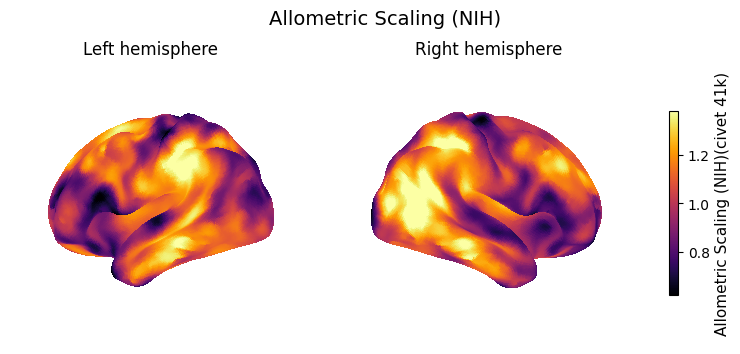

Total time for plotting: 9.09 seconds

[References] Please cite the following papers if you are using this data:

  For {'source': 'reardon2018', 'desc': 'scalingpnc', 'space': 'civet', 'den': '41k'}:
  [primary]:
    PK Reardon, Jakob Seidlitz, Simon Vandekar, Siyuan Liu, Raihaan Patel, Min Tae M Park, Aaron Alexander-Bloch, Liv S Clasen, Jonathan D Blumenthal, Francois M Lalonde, and others. Normative brain size variation and brain shape diversity in humans. Science, 360(6394):1222–1227, 2018.
  [secondary]:
    


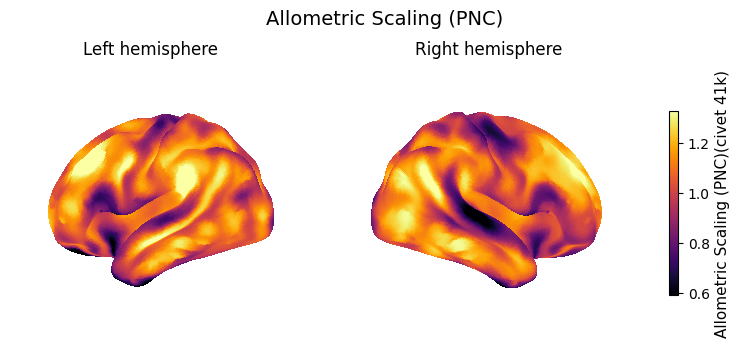

Total time for plotting: 8.21 seconds


In [16]:
for trg_map in target_maps:
    plot_brain_map(trg_map, map_names, brain_map_settings)